In [61]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.data_tools.process_data import process_data

if os.getcwd().split('/')[-1] == 'benchmark_results':
    os.chdir('..')
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
process_data()

Complied Full.csv and Summary.csv.


## Training Graphs

In [62]:
seeds = [12, 13, 14]
rewards = ["Progress", "CTH", "TAL95"]
reward_names = ["Progress", "CTH", "TAL"]

train_maps = ["mco", "gbr", "esp", "aut"]

colors = [periwinkle, minty_green, red_orange]
period = 100

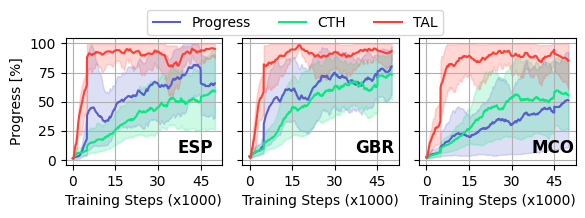

In [63]:
rewards = ["Progress", "CTH", "TAL95"]
total_training_steps = 50000
resampled_xs = np.linspace(0, total_training_steps, 50000)

avg_training_data = {}
min_training_data = {}
max_training_data = {}
downsampled_xs = np.linspace(0, total_training_steps, 1000)

training_data = {}
for train_map in train_maps:
    for reward in rewards:
        temp_progress_data = []
        for seed in seeds:
            test_id = f"TD3_{reward}_{seed}_{train_map}"

            root_path = f"Logs/EndToEnd/RawData_{test_id}/"
            results = pd.read_csv(root_path + f"TrainingData_{test_id}.csv")
            steps = results["Steps"]
            progresses = results["Progress"]*100

            resampled_progress = np.interp(resampled_xs, steps, progresses)
            temp_progress_data.append(resampled_progress)

        avg_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_progress_data, axis=0))
        min_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_progress_data, axis=0))
        max_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_progress_data, axis=0))

plot_maps = ["esp", "gbr", "mco"]
fig, ax = plt.subplots(1, len(plot_maps), figsize=(6, 2), sharex=True, sharey=True)
for i, train_map in enumerate(plot_maps):
    axs = ax[i]
    for j, reward in enumerate(rewards):
        ys = avg_training_data[f"{reward}_{train_map}"]
        ys = true_moving_average(ys, period)
        ax[i].plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average(min_training_data[f"{reward}_{train_map}"], period)
        ys_max = true_moving_average(max_training_data[f"{reward}_{train_map}"], period)
        axs.fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    axs.text(37, 6, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    axs.set_xlabel("Training Steps (x1000)")
    axs.grid()
ax[0].set_ylabel("Progress [%]")
ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4))

h, l = ax[0].get_legend_handles_labels()
fig.legend(h, reward_names, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.savefig(f"{save_path}BenchmarkProgressTraining.pdf", bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"{save_path}BenchmarkProgressTraining.svg", bbox_inches='tight', pad_inches=0.01)

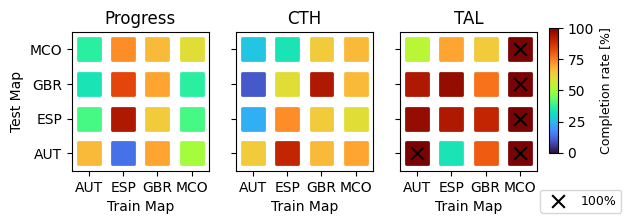

In [64]:
summary_df = pd.read_csv("Logs/Summary.csv")
map_list = ["aut", "esp", "gbr", "mco"]

completion_data = {}
for i, reward in enumerate(rewards):
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        completion_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()

completion_data = pd.concat(completion_data).reset_index().fillna(0)
completion_data["Reward"] = completion_data["level_0"].apply(lambda x: x.split("_")[0])
completion_data["TrainMap"] = completion_data["level_0"].apply(lambda x: x.split("_")[1])
completion_data = completion_data.drop(columns=["level_0", "StdTime"])
completion_data["TestMap"] = completion_data["MapName"].apply(lambda x: x.upper())

completion_data = completion_data[["TrainMap", "Reward", "CompletionRate", "TestMap"]].copy()
completion_data["CompletionRate"] = 100 * completion_data["CompletionRate"]
completion_data["TrainMap"] = completion_data["TrainMap"].apply(lambda x: x.upper())
completion_data["TestMap"] = completion_data["TestMap"]

size = 250

fig, ax = plt.subplots(1, 3, figsize=(6, 1.8), sharex=True, sharey=True)
for i, reward in enumerate(rewards):
    axs = ax[i]
    reward_df = completion_data.loc[completion_data.Reward == reward]

    a = axs.scatter(reward_df["TrainMap"], reward_df["TestMap"], s=size, c=reward_df["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)

    complete_df = reward_df.loc[reward_df.CompletionRate >= 99]
    axs.scatter(complete_df["TrainMap"], complete_df["TestMap"], s=size/3, c='k', marker='x', label="100%")

    complete_df = reward_df.loc[reward_df.CompletionRate <= 0]

    axs.set_title(reward_names[i])
    axs.set_xlabel("Train Map")
    axs.set_xlim(-0.5, 3.5)
    axs.set_ylim(-0.5, 3.5)

ax[0].set_ylabel("Test Map")

ax2 = ax[2]
cax = fig.add_axes([ax2.get_position().x1+0.02, ax2.get_position().y0+0.1, 0.015, ax2.get_position().height*0.9])
cbar = plt.colorbar(a, cax=cax, label="Completion Rate [%]")
cbar.set_label("Completion rate [%]", size=9)
ax[2].legend(loc='center', bbox_to_anchor=(1.32, -0.22), fontsize=9)

plt.savefig(f"{save_path}drl_CompletionRate.pdf", bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"{save_path}drl_CompletionRate.svg", bbox_inches='tight', pad_inches=0.01)


/tmp/ipykernel_918229/3093033871.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


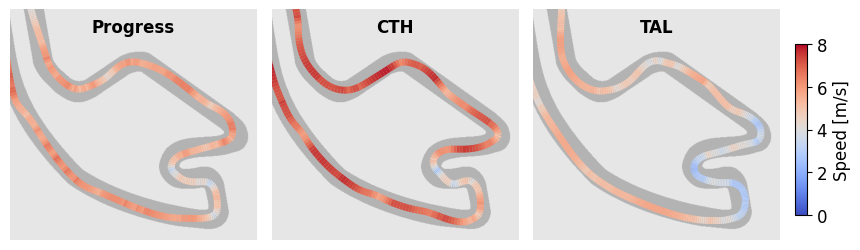

In [65]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
lap_n = 4

map_data = MapData(test_map)
fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 10), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df["slip"] = df["slip"].abs()*180/np.pi

        plt.sca(axs[i])
        map_data.plot_map_img()

        xs, ys = map_data.xy2rc(df.x, df.y)
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        norm = plt.Normalize(0, 8)
        lc = LineCollection(segments, cmap='coolwarm', norm=norm)
        lc.set_array(df.speed.values)
        lc.set_linewidth(5)
        line = plt.gca().add_collection(lc)

        plt.axis('off')
        axs[i].set_aspect('equal')
        plt.xlim(650, 1110)
        plt.ylim(70, 500)
        plt.text(0.5, 0.92, f"{reward_names[i]}", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, fontsize=12, fontweight="bold")

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
cbar = plt.colorbar(line, cax=cax, ticks=[0, 2, 4, 6, 8])
cbar.ax.set_yticklabels([0, 2, 4, 6, 8], fontsize=12)
cbar.set_label("Speed [m/s]", fontsize=12)
plt.tight_layout()

plt.savefig(f"{save_path}drl_speed_trajectories_{test_map}.svg", bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"{save_path}drl_speed_trajectories_{test_map}.pdf", bbox_inches='tight', pad_inches=0.01)


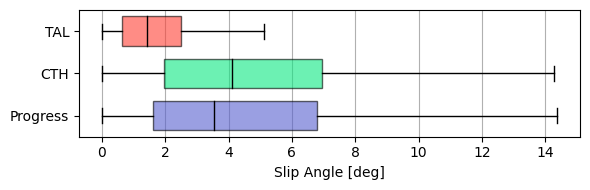

In [66]:
planner_name = "EndToEnd"
seed = 14
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, 1, figsize=(6, 2))

slips_angles = []
for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.slip = df.slip.abs() * 180 / np.pi

        slips_angles.append(df.slip)

# slips_angles.reverse()
# reward_names.reverse()
# colors.reverse()

plt.boxplot(slips_angles, labels=reward_names, showfliers=False, vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='w', color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'), medianprops=dict(color='k'))
for box, color in zip(plt.gca().patches, colors):
    # box.set_facecolor(color, alpha=0.5)
    box.set(facecolor=color, alpha=0.6)

plt.xlabel("Slip Angle [deg]")
plt.grid(True, axis='x')

plt.tight_layout()

plt.savefig(f"{save_path}drl_slip_box_whisker_{test_map}.svg", bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"{save_path}drl_slip_box_whisker_{test_map}.pdf", bbox_inches='tight', pad_inches=0.01)
